In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import time

## Importing Data

In [2]:
#mobile apps are tracked on AppAnnie.  Downloaded reviews from this site
ios_reviews_18 = pd.read_csv('App_Annie_iOS_18.csv')
googplay_reviews_18 = pd.read_csv('App_Annie_Intelligence_Reviews_Google Play_R.B.I. Baseball 18_2018_05_03-2019_07_19_Page_1.csv', header=14)

In [10]:
#Make API calls to Microsoft Xbox/PC game reviews
#This function takes in the URL and creates a dataframe with details about the review and reviewer of the game
def get_reviews(url):
    skip = 0
    has_next_page = True
    reviews_df = pd.DataFrame(columns=['Platform','Market','Locale','SubmittedDateTime','ProductId','PackageVersion','UserName',
                                        'Title','Rating','ReviewId','ReviewText','HelpfulNegative','HelpfulPositive'])
    
    while has_next_page:
        response = requests.get(url,
            params = {'activetab':'pivot:reviewstab','skipItems': skip},
            headers={'ajaxevent': 'pagination','content-length': '0','spamodulename': 'reviewslist'})
        
        json_response = response.json()
        data = json_response['Data']
       
        for item in data['Items']:
            try: 
                version = item['PackageVersion']
            except:
                version = float('NaN')
            
            try:
                title = item['Title']
            except:
                title = float('NaN')
            
            try:
                un = item['UserName']
            except:
                un = float('NaN')
                
            try:
                platform = item['DeviceFamily']
            except:
                platform = float('NaN')
                
            
            reviews_df = reviews_df.append({'Platform': platform,
                                            'HelpfulNegative': item['HelpfulNegative'],
                                            'HelpfulPositive': item['HelpfulPositive'],
                                            'Locale': item['Locale'],
                                            'Market': item['Market'],
                                            'PackageVersion': version,
                                            'ProductId': item['ProductId'], 
                                            'Rating': item['Rating'],
                                            'ReviewId': item['ReviewId'],
                                            'ReviewText': item['ReviewText'],
                                            'SubmittedDateTime': item['SubmittedDateTime'],
                                            'Title': title,
                                            'UserName': un}, ignore_index=True)
                            
        
        print(f'Skip Number: {skip}')
        print('Reviews Collected: ', len(data["Items"]))
        print('Total Reviews: ', data["PagingInfo"]["TotalItems"])
        
        skip += 10
        
        if data["PagingInfo"]["TotalItems"] > skip:
            has_next_page = True
        else:
            has_next_page = False
        
        time.sleep(10)
    
    return reviews_df
      

In [11]:
#calling get_reviews for the microsoft API
xbox_reviews_18 = get_reviews('https://www.microsoft.com/en-us/p/rbi-baseball-18/bqlf1tjl4hzb')

Skip Number: 0
Reviews Collected:  10
Total Reviews:  146
Skip Number: 10
Reviews Collected:  10
Total Reviews:  146
Skip Number: 20
Reviews Collected:  10
Total Reviews:  146
Skip Number: 30
Reviews Collected:  10
Total Reviews:  146
Skip Number: 40
Reviews Collected:  10
Total Reviews:  146
Skip Number: 50
Reviews Collected:  10
Total Reviews:  146
Skip Number: 60
Reviews Collected:  10
Total Reviews:  146
Skip Number: 70
Reviews Collected:  10
Total Reviews:  146
Skip Number: 80
Reviews Collected:  10
Total Reviews:  146
Skip Number: 90
Reviews Collected:  10
Total Reviews:  146
Skip Number: 100
Reviews Collected:  10
Total Reviews:  146
Skip Number: 110
Reviews Collected:  10
Total Reviews:  146
Skip Number: 120
Reviews Collected:  10
Total Reviews:  146
Skip Number: 130
Reviews Collected:  10
Total Reviews:  146
Skip Number: 140
Reviews Collected:  6
Total Reviews:  146


## Exploring the Data

In [13]:
#eda function takes in a dataframe and the columns you'd like to be the same for a review to be considered a duplicate
#and prints out descriptive statistics about the df
def eda(df, dup_columns):
    print(df.info())
    print('--------------------------------')
    print(df.describe())
    print('--------------------------------')
    for column in list(df.columns):
        print(df[column].value_counts())
        print('--------------------------------')
    print(df[df.duplicated(dup_columns)])
    

### iOS DF

In [ ]:
eda(ios_reviews_18,['Version', 'Rating', 'Review (Translated)'])

In [ ]:
#Checking date range makes sense
set(ios_reviews_18['Date'])

### Google Play DF

In [ ]:
eda(googplay_reviews_18, ['Version', 'Rating', 'Review (Translated)'])

In [27]:
print(len(googplay_reviews_18))
googplay_reviews_18.drop_duplicates(['Version', 'Rating', 'Review (Translated)'],inplace=True)
print(len(googplay_reviews_18))

249
241


### Xbox DF

In [ ]:
eda(xbox_reviews_18, ['PackageVersion', 'Rating', 'ReviewText'])

In [34]:
xbox_reviews_18['Date'] = [dtstring[:10] for dtstring in xbox_reviews_18['SubmittedDateTime']]

In [ ]:
set(xbox_reviews_18['Date'])

## Combining Dataframes

In [114]:
ios_18 = ios_reviews_18[['Platform','Date','Version','Rating','Title (Translated)','Review (Translated)']].copy()
ios_18.columns=['Platform', 'Date', 'Version', 'Rating','Title', 'Review']

In [115]:
gp_18 = googplay_reviews_18[['Platform', 'Date', 'Version', 'Rating', 'Title (Translated)', 'Review (Translated)']].copy()
gp_18.columns = ['Platform', 'Date', 'Version', 'Rating', 'Title', 'Review']

In [116]:
xbox_18 = xbox_reviews_18[['Platform', 'Date', 'PackageVersion', 'Rating', 'Title','ReviewText']].copy()
xbox_18.columns = ['Platform', 'Date', 'Version', 'Rating', 'Title', 'Review']

In [40]:
reviews_18 = pd.concat([ios_18,gp_18,xbox_18], ignore_index=True)

In [75]:
reviews_18['Rating'].mean()

2.5647263249348393

In [112]:
eda(reviews_18,['Version', 'Rating', 'Review'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 7 columns):
Platform    1141 non-null object
Date        1151 non-null object
Version     1060 non-null object
Rating      1151 non-null object
Title       904 non-null object
Review      1151 non-null object
text        1151 non-null object
dtypes: object(7)
memory usage: 63.0+ KB
None
--------------------------------
       Platform        Date Version  Rating     Title Review  text
count      1141        1151    1060    1151       904   1151  1151
unique        4         339      14       5       761   1128  1120
top         iOS  2018-03-28   1.0.6       1  Terrible   good  good
freq        764          45     188     471         8      3     5
--------------------------------
iOS                764
Google Play        241
Windows.Xbox       124
Windows.Desktop     12
Name: Platform, dtype: int64
--------------------------------
2018-03-28    45
2018-03-29    43
2018-03-30    28
2018-03-31  

## Visualizations

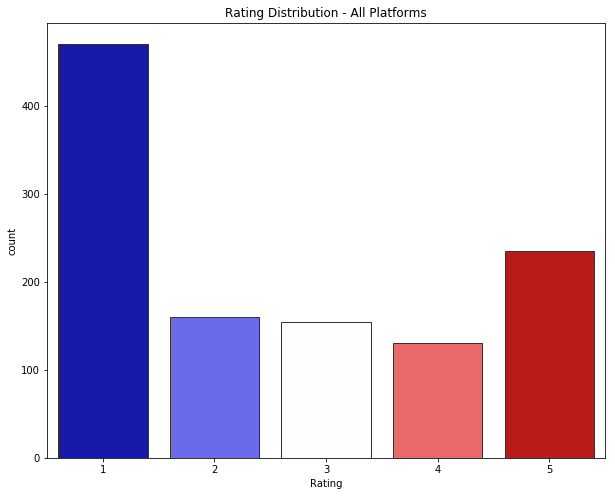

In [42]:
plt.figure(figsize=(10,8))
sns.countplot(x='Rating', data=reviews_18, palette = 'seismic', edgecolor='.2')
plt.title('Rating Distribution - All Platforms');

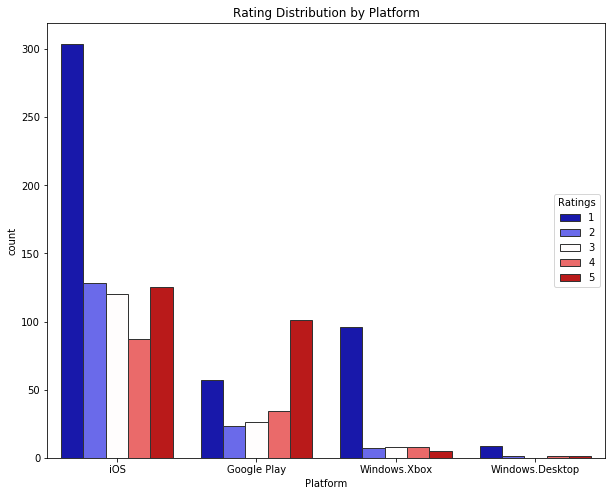

In [43]:
plt.figure(figsize=(10,8))
sns.countplot(x='Platform', hue='Rating', data=reviews_18, palette = 'seismic', edgecolor='.2')
plt.title('Rating Distribution by Platform')
plt.legend(title="Ratings", loc='right');

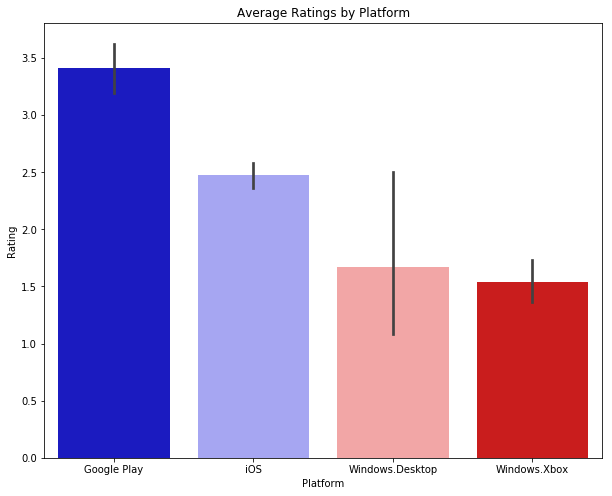

In [44]:
plt.figure(figsize=(10,8))
sns.barplot(x=reviews_18['Platform'], y=reviews_18['Rating'], palette = 'seismic',order=['Google Play', 'iOS', 'Windows.Desktop', 'Windows.Xbox'] )
plt.title('Average Ratings by Platform');

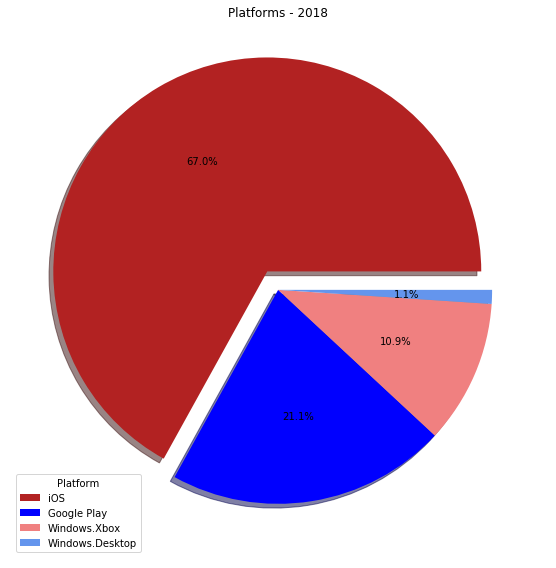

In [45]:
plt.figure(figsize=(10,8))
plt.pie(reviews_18['Platform'].value_counts(), 
        autopct='%1.1f%%', 
        explode=(.1, 0,0,0), 
        shadow=True,
        colors=['firebrick','blue','lightcoral','cornflowerblue'])
plt.legend(labels=reviews_18['Platform'].value_counts().index, title='Platform',loc="best")
plt.title('Platforms - 2018')
plt.tight_layout()
plt.show()

## NLP

In [46]:
from gensim.summarization import summarize, keywords

In [47]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Preprocessing

In [49]:
stoplist = stopwords.words('english')+['baseball','every','ball','hit']

In [50]:
lemmer = WordNetLemmatizer()

def lower(review):
    lowercase_review = review.lower()
    return lowercase_review

def remove_punc(lowercase_review):
    stripped_review = lowercase_review.translate(str.maketrans('', '', string.punctuation))
    stripped_review.replace('\n',' ')
    return stripped_review

def lem_reviews(stripped_review, lemmer):
    lems = lemmer.lemmatize(stripped_review)
    return lems

def normalize(review, lemmer):
    lower_rev = lower(review)
    no_punc = remove_punc(lower_rev)
    lems = lem_reviews(no_punc, lemmer)
    return lems

In [51]:
reviews_18['text'] = reviews_18['Review'].apply(lambda x: normalize(x, lemmer))

In [56]:
vec = TfidfVectorizer(stop_words=stoplist, ngram_range=(1,3))
total_transform = vec.fit_transform(reviews_18['text'])
features = vec.get_feature_names()

In [57]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(14, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title(str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    fig.text(0.5, 0.04,"Word Importance (Mean TF-IDF Score)", ha='center',fontsize=12)
    plt.show()

In [111]:
top_mean_feats(total_transform,features)

,feature,tfidf
0,game,0.013007
1,good,0.011683
2,awesome,0.007364
3,good game,0.005839
4,fun,0.005837
5,best,0.005715
6,refund,0.005599
7,great,0.005531
8,money,0.005249
9,ever,0.004514


In [59]:
dfs = top_feats_by_class(total_transform, reviews_18['Platform'].dropna(),features)

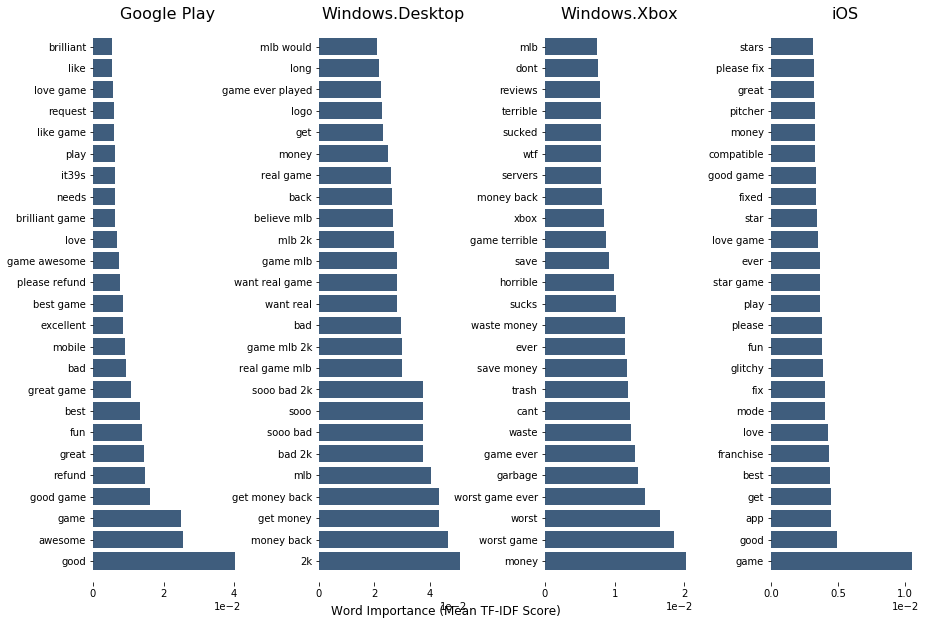

In [60]:
plot_tfidf_classfeats_h(dfs)

In [62]:
dfs_by_rating = top_feats_by_class(total_transform, reviews_18['Rating'],features)

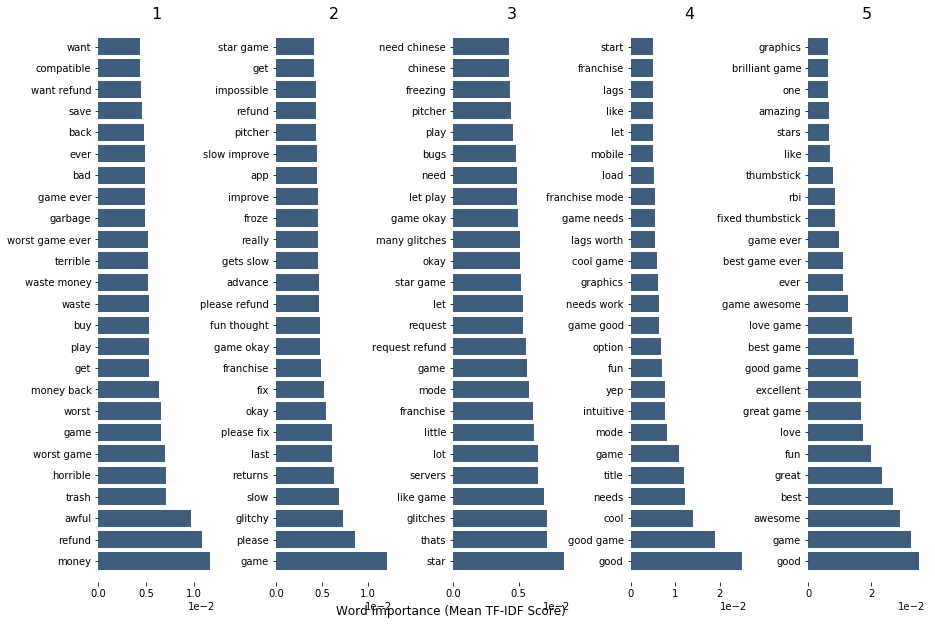

In [63]:
plot_tfidf_classfeats_h(dfs_by_rating)

### Sentiment Analysis and Most Polar Words

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [65]:
sent_vec = TfidfVectorizer(stop_words=stoplist)
sent_transform = sent_vec.fit_transform(reviews_18['text'])
sent_feats = sent_vec.get_feature_names()

In [66]:
sia = SentimentIntensityAnalyzer()
feat_polarity = [(word, sia.polarity_scores(word)['compound']) for word in sent_feats]

In [67]:
def polar_words(sentiments):
    polar_words = [(word,score) for word,score in sentiments if score != 0]
    return polar_words
    

def most_polar_words(sentiments, neg_bound=-.5, pos_bound=.5):
    most_polar_words = [(word,score) for word,score in polar_words(sentiments) if score < neg_bound or score > pos_bound]
    return most_polar_words


In [68]:
most_polar = most_polar_words(feat_polarity,-.55,.55)

In [69]:
most_polar=pd.DataFrame(most_polar, columns=['word','polarity'])

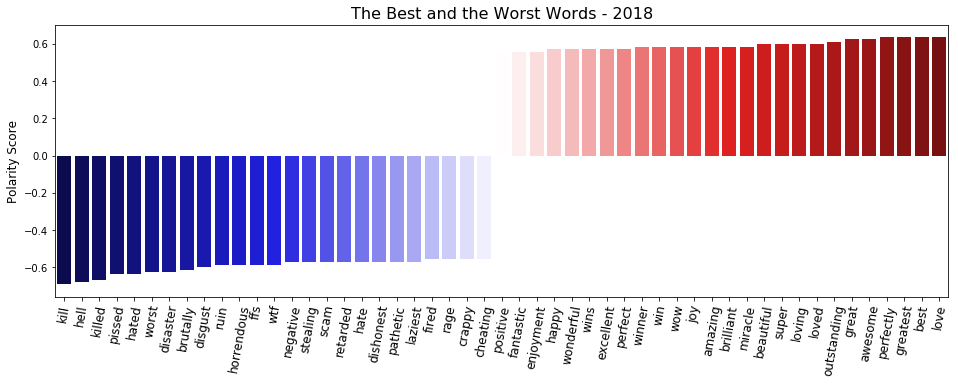

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (16, 5))

sns.barplot(x=most_polar.sort_values(['polarity'])['word'], y=most_polar.sort_values(['polarity'])['polarity'], palette="seismic")

ax.set_ylabel('Polarity Score', fontsize=12)    
ax.set_xlabel('')

plt.title('The Best and the Worst Words - 2018', fontsize=16)
plt.xticks(rotation=80, fontsize = 12);
